# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [6]:
import copy
import random
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

from typing import NoReturn, Tuple, List

In [31]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        
        return self
    
    def transform(self, X):
        new_X = np.copy(X)
        
        return (new_X - self.mean) / self.std
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [7]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 0 соответствует доброкачественной опухоли (M), 
        1 --- злокачественной (B).

    
    """
    data = pd.read_csv(path_to_csv).sample(frac=1)
    X, y = data.drop("label", 1), data["label"].map({"M": 0, "B": 1})
    
    return X.values, y.values

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    data = pd.read_csv(path_to_csv).sample(frac=1)
    X, y = data.drop("label", 1), data["label"]
    
    return X.values, y.values

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [8]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    split_idx = int(X.shape[0] * ratio)
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
        
    return X_train, y_train, X_test, y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [9]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    classes = np.unique(y_true)
    recall, precision = np.zeros(classes.shape[0]), np.zeros(classes.shape[0]) 
    
    for i, cls in enumerate(classes):
        cls_true = (y_true == cls).astype(np.int)
        cls_pred = (y_pred == cls).astype(np.int)
        
        tp = np.sum(cls_pred[cls_true == 1] == 1)
        fp = np.sum(cls_pred[cls_true == 0] == 1)
        fn = np.sum(cls_pred[cls_true == 1] == 0)
        
        recall[i] = tp / (tp + fn)
        precision[i] = tp / (tp + fp)
        
    accuracy = np.sum(y_true == y_pred) / y_true.shape[0]
    
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [10]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (16, 6))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        plt.grid(linestyle='--', color='gray', alpha=0.5)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [11]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
#         for w in np.arange(0.00, 1.00, 100):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (12, 8))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c, linewidth=0.8)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.grid(linestyle='--', color='gray', alpha=0.5)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [12]:
# я что зря страдал эти два модуля на алгоритмах, да этоже мердж двух сортированных массивов, это я умею
def merge_neigh(dists1, dists2, k):
    neigh1, dist1 = dists1
    neigh2, dist2 = dists2
    
    new_neigh, new_dist = [], []
    
    i, j = 0, 0
    while i < len(dist1) and j < len(dist2) and len(new_dist) < k:
        if dist1[i] <= dist2[j]:
            new_neigh.append(neigh1[i])
            new_dist.append(dist1[i])
            i += 1
        else:
            new_neigh.append(neigh2[j])
            new_dist.append(dist2[j])
            j += 1
    
    while i < len(dist1) and len(new_dist) < k:
        new_neigh.append(neigh1[i])
        new_dist.append(dist1[i])
        i += 1
        
    while j < len(dist2) and len(new_dist) < k:
        new_neigh.append(neigh2[j])
        new_dist.append(dist2[j])
        j += 1

    return np.array(new_neigh), np.array(new_dist)

In [15]:
class Node:
    def __init__(self, median=None, axis=None, data=None):
        self.median = median
        self.axis = axis
        self.data = data
        
        self.left = None
        self.right = None
        
        
    @property
    def leaf(self): 
        return (self.left is None and self.right is None)
        
    def nearest_neighbors(self, point, k):
        if not self.leaf:
            raise ValueError("Not a leaf!") 
        
        dist = np.sqrt(np.sum((self.data[:, 1:] - point)**2, axis=1))
        nearest_idx = np.argsort(dist)[:k]  # maybe partial sort is better np.argpartition() -> sort = O(n + klogk)
        
        return self.data[nearest_idx, 0], dist[nearest_idx]


class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """        
        self.X = np.hstack([np.arange(X.shape[0]).reshape(-1, 1), X])
        self.leaf_size = leaf_size
        
        self.dim = X.shape[1]
        self.root = self._build_tree(self.X)
        
    def _build_tree(self, X, depth=0):
        X_dim = X[:, (depth % self.dim) + 1]
        
        median = np.median(X_dim)
        X_left, X_right = X[X_dim < median], X[X_dim >= median]
        
        if X_left.shape[0] < self.leaf_size or X_right.shape[0] < self.leaf_size:
            return Node(data=X)
        
        root = Node(median=median, axis=(depth % self.dim) + 1)
        root.left = self._build_tree(X_left, depth + 1)
        root.right = self._build_tree(X_right, depth + 1)
            
        return root
    
    def _query(self, root, point, k):
        if root.leaf:
            return root.nearest_neighbors(point, k)
        
        axis = root.axis - 1
        
        if point[axis] < root.median:
            neighbors, dist = self._query(root.left, point, k)
            other_node = root.right
        else:
            neighbors, dist = self._query(root.right, point, k)
            other_node = root.left
        
        if len(neighbors) < k or dist[-1] >= abs(point[axis] - root.median):
            new_neighbors, new_dist = self._query(other_node, point, k)
            
            return merge_neigh((neighbors, dist), (new_neighbors, new_dist), k)
        
        return neighbors, dist
        
    
    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.

        """
        neighbors = np.zeros((X.shape[0], k), dtype=np.int)

        for i, point in enumerate(X):
            neighs, dists = self._query(self.root, point, k=k)
            neighbors[i] = neighs
        
        return neighbors

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [16]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

for _ in range(100):
    X_train = np.random.randn(100, 3)
    X_test = np.random.randn(10, 3)

    tree = KDTree(X_train, leaf_size=2)
    predicted = tree.query(X_test, k=4)
    true = true_closest(X_train, X_test, k=4)

    if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
        print("Wrong shape")
    else:
        errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
        if errors > 0:
            print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [17]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """
        self.k = n_neighbors
        self.leaf_size = leaf_size
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """ 
        self.y = y
        self.classes = np.unique(y)
        self.tree = KDTree(X, leaf_size=self.leaf_size)
        
        return self
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        nearest_neighs = self.tree.query(X, k=self.k)
        pred_class = self.y[nearest_neighs]
        pred_proba = np.zeros((X.shape[0], self.classes.shape[0]))
        
        for i, cls in enumerate(self.classes):
            pred_proba[:, i] = np.sum(pred_class == cls, axis=1)
        
        return pred_proba / self.k
    
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

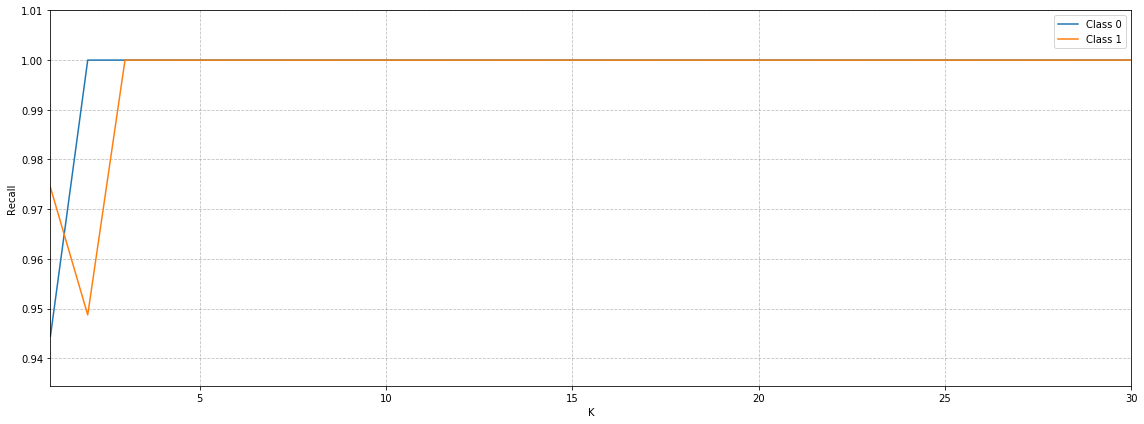

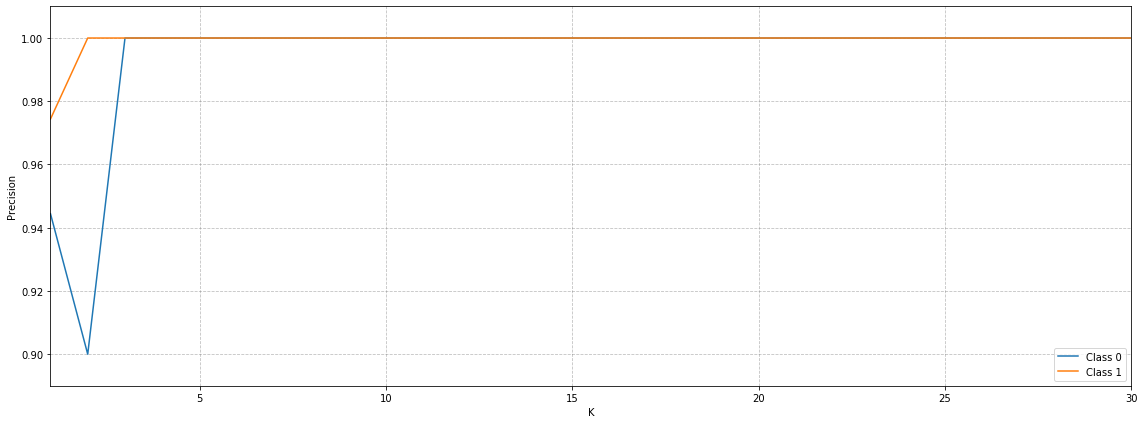

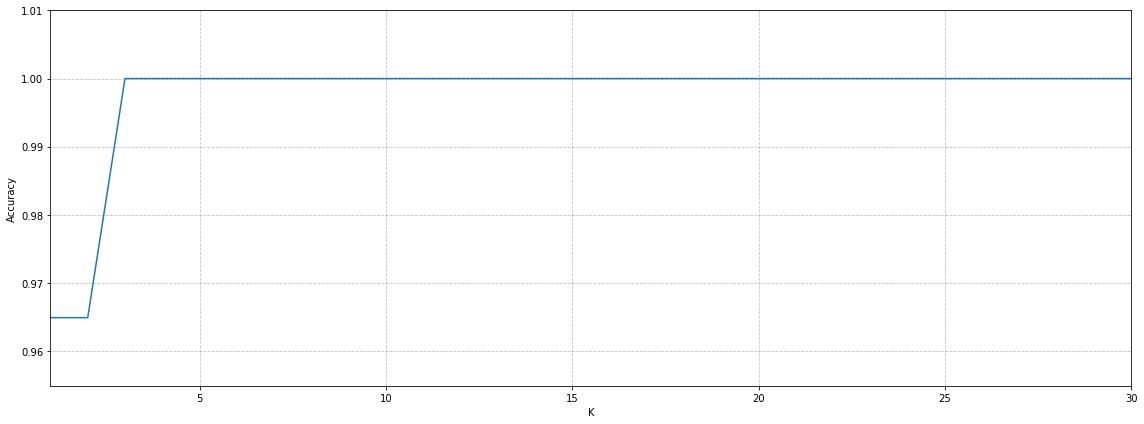

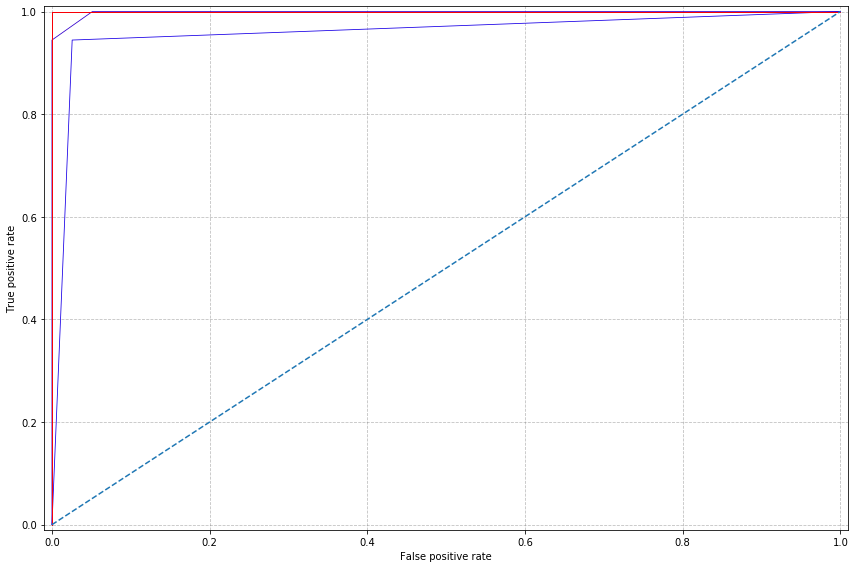

CPU times: user 4.46 s, sys: 122 ms, total: 4.58 s
Wall time: 4.5 s


In [36]:
%%time
scaler = StandardScaler()
X, y = read_cancer_dataset("cancer.csv")

X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

plot_precision_recall(X_train_scaled, y_train, X_test_scaled, y_test)
plot_roc_curve(X_train_scaled, y_train, X_test_scaled, y_test, max_k=10)

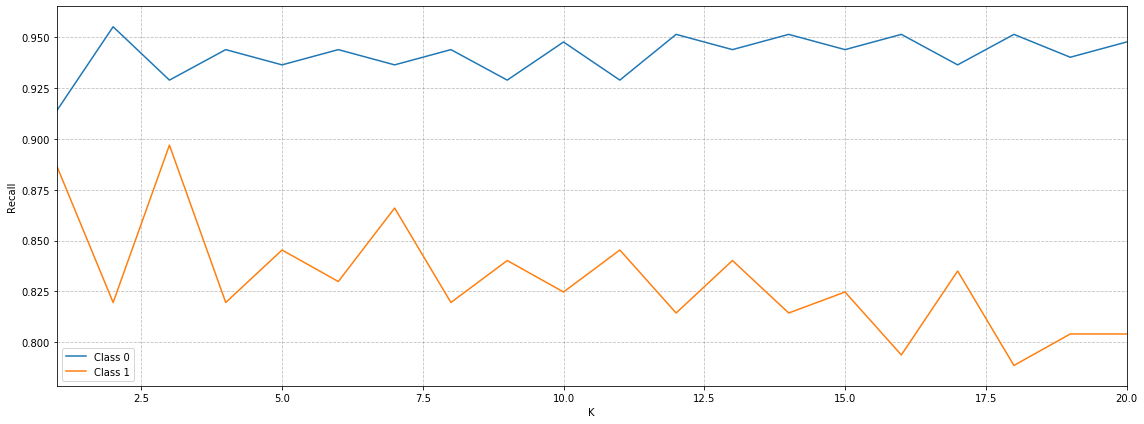

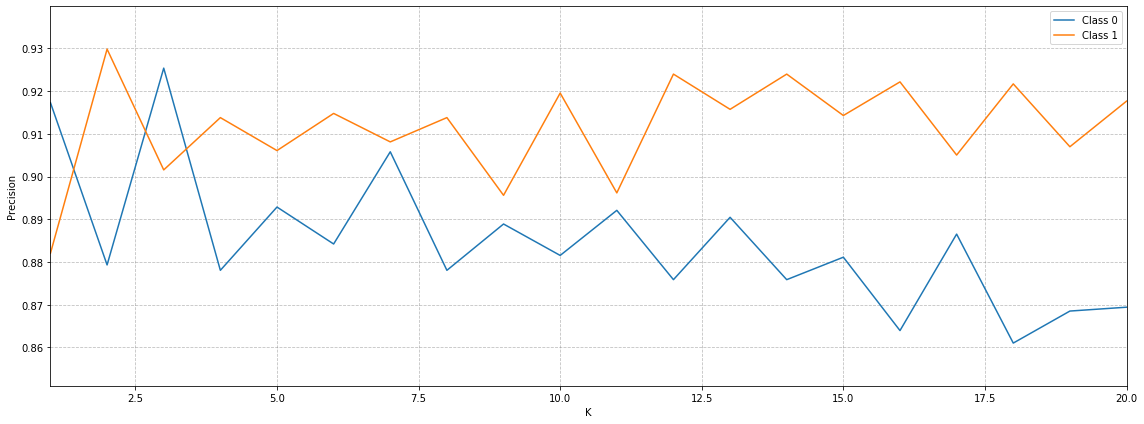

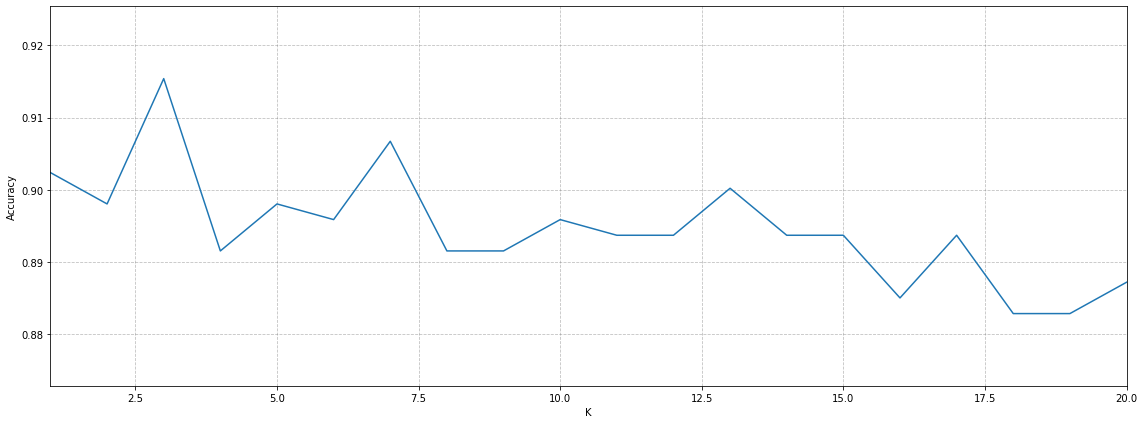

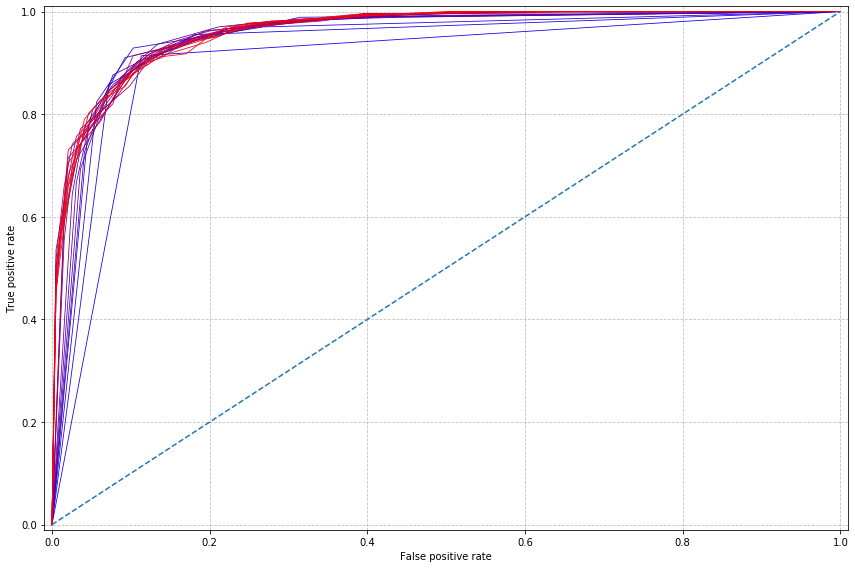

CPU times: user 30.5 s, sys: 811 ms, total: 31.3 s
Wall time: 37.6 s


In [38]:
%%time
scaler = StandardScaler()
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

plot_precision_recall(X_train_scaled, y_train, X_test_scaled, y_test, max_k=20)
plot_roc_curve(X_train_scaled, y_train, X_test_scaled, y_test, max_k=20)